In [1]:
import phylovelo as pv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
%matplotlib inline
from itertools import product
from scipy.stats import nbinom
from matplotlib_venn import venn3

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# tree_file = 'tree_origin_var0.02_rvg0.05.csv0'
# reconstruct('../datas/line_model/'+tree_file, output='../datas/line_model/'+tree_file+'.nwk', num=1000, is_balance=True)

In [20]:
data_path = '/data3/wangkun/phylovelo_datasets/'

In [21]:
tree_file = data_path + 'linear_model/tree_origin_var0.02_rvg0.05.csv0.nwk'

In [22]:
phylo_tree, branch_colors = pv.loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
# fig, ax = plt.subplots(figsize=(10,20))
# plot_tree(phylo_tree, branch_colors, ax=ax, stain='terminals')

In [23]:
cell_names, cell_states, cell_generation = pv.get_annotation(data_path + 'linear_model/tree_origin_var0.02_rvg0.05.csv0')

In [24]:
cell_states = pd.DataFrame(data=cell_states, index=cell_names)
cell_states = cell_states.loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names)
cell_generation = cell_generation.loc[sampled_cells]
cell_generation = cell_generation.to_numpy()

In [9]:
sd = pv.scData(phylo_tree=phylo_tree, 
            cell_states=cell_states.to_numpy().T[0].astype('int'), 
            cell_generation=cell_generation.T[0].astype('int'),
            cell_names=sampled_cells)

In [21]:
ge, base_expr = sim_base_expr(sd.phylo_tree, 
                                 cell_states,
                                 Ngene=2000, 
                                 r_variant_gene=0.4, 
                                 variance=0.01, 
                                 diff_map={0:[0],1:[0],2:[1],3:[2],4:[3]},
                                 forward_map={},
                                 mu0_loc=0, 
                                 mu0_scale=1, 
                                 drift_loc=0, 
                                 drift_scale=0.3,
                                )

/home/wangkun/LineageTracingwithscRNA/sim_utils.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  base_expr[cell.name] = ge.expr(cellstate, int(terminals_depths[cell]) - t0 - start_time[cellstate] + pseudo_start_time[cellstate])


In [23]:
sd.count = get_count_from_base_expr(add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.1)

In [30]:
sd.dimensionality_reduction(methor='tsne', scale=10, n_highly_variable_genes=0, perplexity=30, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


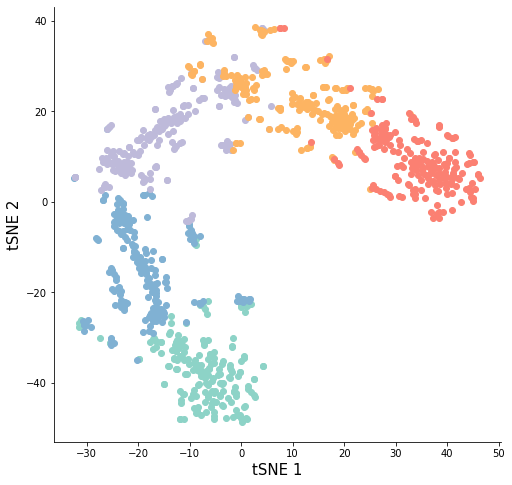

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
plt.savefig('./figures/Linear/tsne.pdf', dpi='figure', format='pdf')

In [32]:
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

In [82]:
sd = velocity_inference(sd, sd.cell_generation, cutoff=0.9, target='count', exact=True)

/home/wangkun/LineageTracingwithscRNA/inference.py:16: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros*np.log((1-psi)+psi*(n/(n+mu))**n)
/home/wangkun/LineageTracingwithscRNA/inference.py:173: RuntimeWarning: invalid value encountered in log
  y = np.log(y+1)


In [83]:
sd = velocity_embedding(sd, target='count')

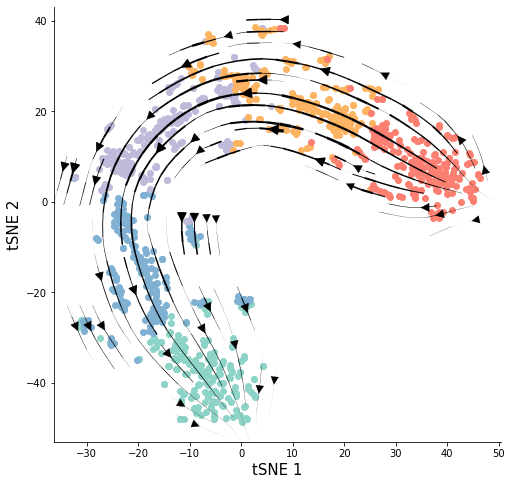

In [87]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
plt.savefig('./figures/Linear/stream.pdf', dpi='figure', format='pdf')

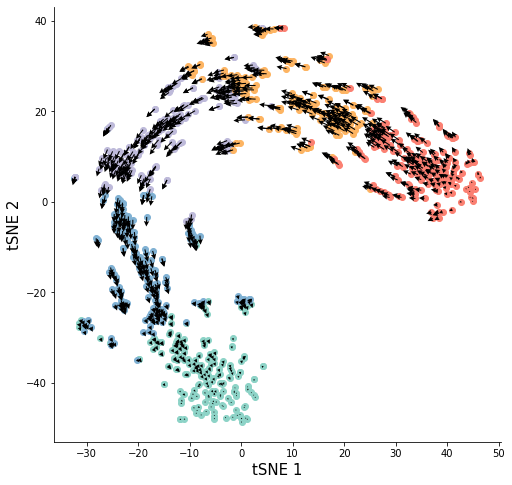

In [85]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'point',streamdensity=1, radius=5, lw_coef=500,headwidth=5)
ax.figure.set_size_inches(8,8)
# ax.set_title('Branch model', fontsize=15)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
plt.savefig('./figures/Linear/quiver.pdf', dpi='figure', format='pdf')

In [3]:
from matplotlib_venn import venn3

In [5]:
import pickle

In [6]:
sd = pickle.load(open('/data3/wangkun/result_sd/simulation_linear.pkl', 'rb'))
drifts = pd.read_csv('/data3/wangkun/phylovelo_datasets/linear_model/drifts.csv', index_col=0)

In [27]:
pv.velocity_inference(sd, cell_generation.flatten(), cutoff=0.9, target='count', exact=True)
pv.velocity_embedding(sd, target='count')

  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

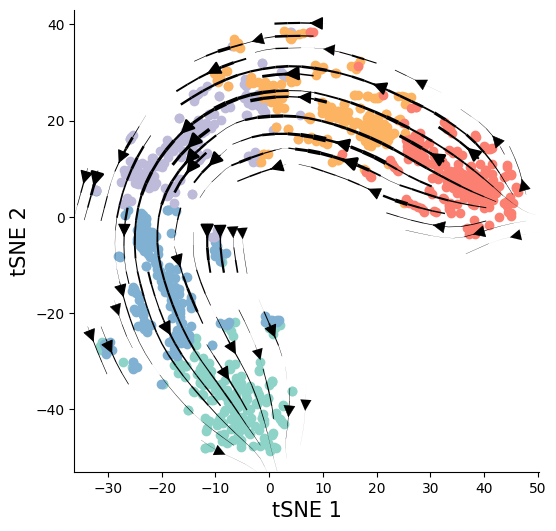

In [28]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [78]:
mutation_tree = deepcopy(sd.phylo_tree)
mut_rate = 1
for i in mutation_tree.get_nonterminals():
    i.branch_length = np.random.poisson(mut_rate)

for i in mutation_tree.get_terminals():
    i.branch_length = np.random.poisson(mut_rate)

depths1 = np.array([mutation_tree.depths()[mutation_tree.find_any(name=i)] for i in sd.count.index])

In [79]:
sd = velocity_inference(sd, depths1, cutoff=0.9, target='count', exact=True)
sd = velocity_embedding(sd, target='count')

/home/wangkun/LineageTracingwithscRNA/inference.py:16: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros*np.log((1-psi)+psi*(n/(n+mu))**n)
/home/wangkun/LineageTracingwithscRNA/inference.py:173: RuntimeWarning: invalid value encountered in log
  y = np.log(y+1)


mu=1


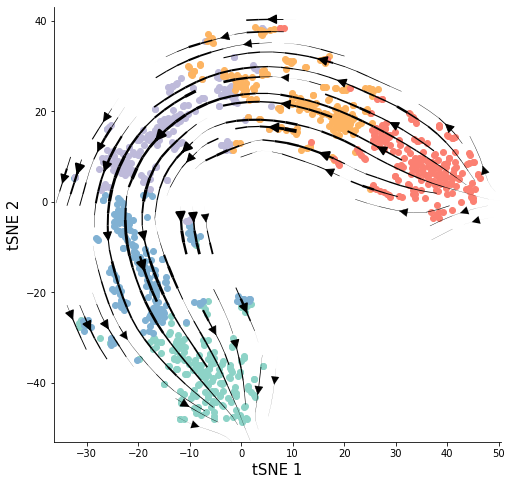

In [80]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=800, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
print('mu=1')

mu=0.3


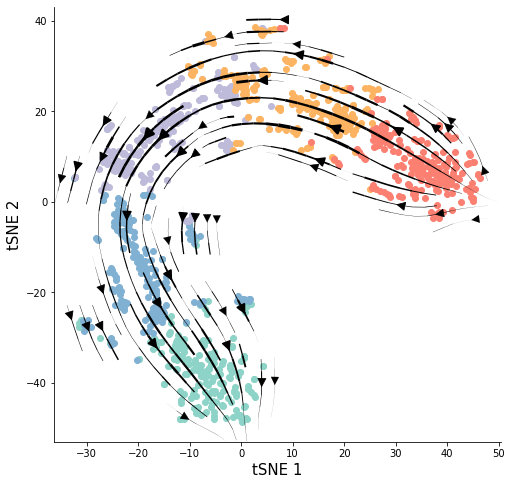

In [70]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=800, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
print('mu=0.3')

mu=0.1


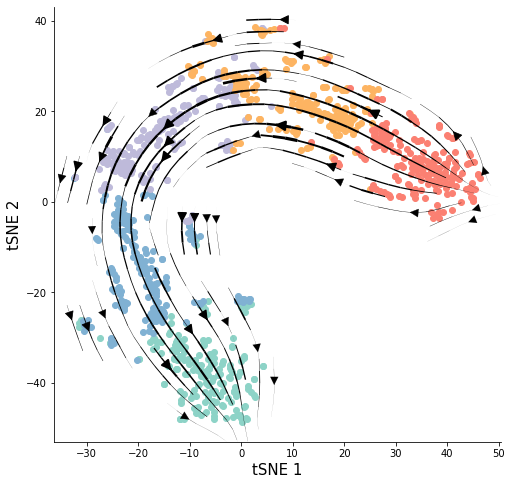

In [77]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=500, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_ylim(-50, 35)
print('mu=0.1')

In [124]:
cell_type_map = dict(zip([branch_colors[i][:-2] for i in range(len(branch_colors))], [branch_colors[i][-1] for i in range(len(branch_colors))]))

In [357]:
mutation_tree = deepcopy(sd.phylo_tree)
mut_rate = 0.1
for i in mutation_tree.get_nonterminals():
    i.branch_length = np.random.poisson(mut_rate)

for i in mutation_tree.get_terminals():
    i.branch_length = np.random.poisson(mut_rate)

In [358]:
Phylo.write(mutation_tree, 'linear_0.1', format='newick')

1

In [449]:
import seaborn as sns
from sklearn.preprocessing import scale

def expr_sort(gene, states):
    expr = []
    for state in states:
        t = list(ge.expr_rec[state].keys())
        t.sort()
        expr.append([ge.expr_rec[state][i][gene] for i in t])
    return sum(expr, [])

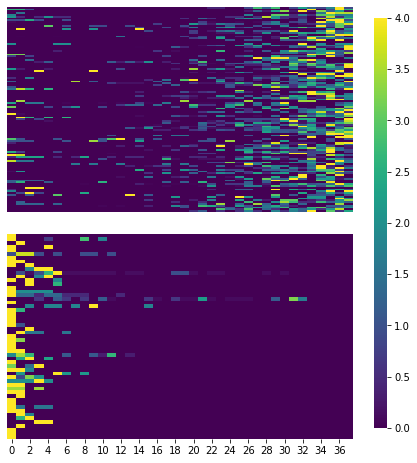

In [522]:
fig = plt.figure(figsize=(6, 6))
h1 = 0.5
h2 = 0.5
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

expr_mat = np.array([expr_sort(i, range(5)) for i in drifts.loc[megs].index[drifts.loc[megs][4]<0]])
# expr_mat = expr_mat[expr_mat[:,0]!=0]
expr_mat = get_count_from_base_expr(pd.DataFrame(expr_mat), alpha= 0.1)
for i in expr_mat.index:
    expr_mat.loc[i] = scale(expr_mat.loc[i])
ax1 = sns.heatmap(expr_mat[expr_mat.sum(axis=1)!=0], cmap='viridis', ax=ax1, vmax=4, vmin=0, cbar_ax=ax3, yticklabels='')
n1 = sum(expr_mat.sum(axis=1)!=0)

expr_mat = np.array([expr_sort(i, range(5)) for i in drifts.loc[megs].index[drifts.loc[megs][4]>0]])
expr_mat = expr_mat[expr_mat[:,0]!=0]
expr_mat = get_count_from_base_expr(pd.DataFrame(expr_mat), alpha= 0.1)
for i in expr_mat.index:
    expr_mat.loc[i] = scale(expr_mat.loc[i])
ax2 = sns.heatmap(expr_mat.sample(169-n1), cmap='viridis', ax=ax2, cbar=False, vmax=3, vmin=0, xticklabels=False, yticklabels='')

In [631]:
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']

In [642]:
import seaborn as sns

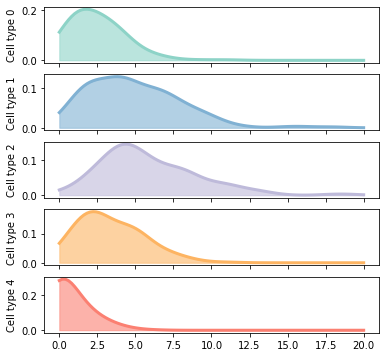

In [832]:
fig, ax = plt.subplots(5, 1, figsize=(6, 6), sharex=True)
g = 99
from sklearn.neighbors import KernelDensity
for i in range(5):  
    ax[i].set_ylabel(f'Cell type {i}', fontsize=10)
    data_kde = sd.count[g][sd.cell_states==i].to_numpy()
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(data_kde[:, np.newaxis])
    x_kde = np.linspace(0,20,100)
    y_kde = np.exp(kde.score_samples(x_kde[:, np.newaxis]))
    ax[i].plot(x_kde, y_kde, c=cmps[i], lw=3)
    ax[i].fill_between(x_kde, y_kde, color=cmps[i], alpha=0.6)
    # ax[i].vlines(np.mean(data_kde), 0, np.exp(kde.score_samples([[np.mean(data_kde)]])), color='black', lw=2)
    
# ax[i].set_xlabel(f'Cell', fontsize=15)

In [839]:
model = 'linear'
from scipy.stats import zscore
sd.count.to_csv(f'{model}_cnt.csv')
sd.normalize_filter()
sd.x_normed.to_csv(f'{model}_norm.csv')
zscore(sd.x_normed).to_csv(f'{model}_zscore.csv')

In [888]:
from copy import deepcopy

In [895]:
tree, branch_colors = loadtree(tree_file)
mutations = dict()
global_mutid = 0

In [917]:
mu = 0.3
for i in tree.get_terminals():
    mut = []
    for j in tree.get_path(i):
        if j.name in mutations:
            mut = deepcopy(mutations[j.name])
        else:
            for _ in range(np.random.poisson(mu)):
                mut.append(global_mutid+1)
                global_mutid += 1
            mutations[j.name] = deepcopy(mut)

mut_table = []
cell_nemes = []
for i in tree.get_terminals():
    seq = np.zeros(global_mutid+1)
    seq[mutations[i.name]]=1
    mut_table.append(seq)
    cell_nemes.append(i.name)

In [924]:
mut_table = pd.DataFrame(data=mut_table, index=cell_nemes).iloc[:,1:]
mut_table.astype('int').to_csv('Linear.csv')

In [15]:
tree, branch_colors = pv.loadtree(tree_file)
mutations = dict()

mu = 1
len_seq = 500
for i in tree.get_terminals():
    mut = np.zeros(len_seq)
    for j in tree.get_path(i):
        if j.name in mutations:
            mut = deepcopy(mutations[j.name])
        else:
            mut[np.random.choice(range(len_seq), np.random.poisson(mu))] = 1
            mutations[j.name] = deepcopy(mut)

mut_table = []
cell_nemes = []
for i in tree.get_terminals():
    mut_table.append(mutations[i.name])
    cell_nemes.append(i.name)

In [16]:
mut_table = pd.DataFrame(data=mut_table, index=cell_nemes).astype('int')
with open('/data3/wangkun/linear.phy', 'w') as f:
    f.write('{} {}\n'.format(*mut_table.shape))
    for cell in mut_table.index:
        f.write('{} {}\n'.format(cell[1:-1], ''.join(mut_table.loc[cell].astype(str)).replace('0', 'A').replace('1', 'G')))

In [17]:
from Bio import Phylo
tree_nj = Phylo.read('/data3/wangkun/linear_nj.nwk', 'newick')
tree_mp = Phylo.read('/data3/wangkun/linear_mp.nwk', 'newick')
tree_ml = Phylo.read('/data3/wangkun/linear.phy.treefile', 'newick')

In [22]:
tree_depths = tree_nj.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths_nj = [depths_map[i[1:-1]] for i in cell_nemes]

tree_depths = tree_mp.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths_mp = [depths_map[i[1:-1]] for i in cell_nemes]

tree_depths = tree_ml.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths_ml = [depths_map[i[1:-1]] for i in cell_nemes]

In [30]:
tree_depths = tree_nj.depths()
depths_map = dict()
for i in tree_nj.get_terminals():
    depths_map[i.name] = len(tree_nj.get_path(i))
depths_nj = [depths_map[i[1:-1]] for i in cell_nemes]

tree_depths = tree_mp.depths()
depths_map = dict()
for i in tree_mp.get_terminals():
    depths_map[i.name] = len(tree_mp.get_path(i))
depths_mp = [depths_map[i[1:-1]] for i in cell_nemes]

tree_depths = tree_ml.depths()
depths_map = dict()
for i in tree_ml.get_terminals():
    depths_map[i.name] = len(tree_ml.get_path(i))
depths_ml = [depths_map[i[1:-1]] for i in cell_nemes]

<AxesSubplot: >

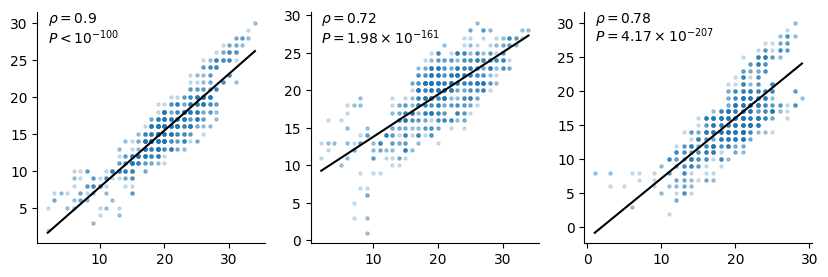

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
corr_plot(depths_mp, depths_nj, ax[0], 'spearman')
corr_plot(depths_mp, depths_ml, ax[1], 'spearman')
corr_plot(depths_ml, depths_nj, ax[2], 'spearman')

In [23]:
import pickle
sd = pickle.load(open('/data3/wangkun/result_sd/simulation_linear.pkl', 'rb'))
dir_gt = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

In [33]:
sd.normalize_filter()

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/data_struct.py:114: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.x_normed = np.divide(self.count, counts_per_cell[:, None])


In [35]:
sd = pv.velocity_inference(sd, depths_nj, exact=True)
sd = pv.velocity_embedding(sd)
dir_nj = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

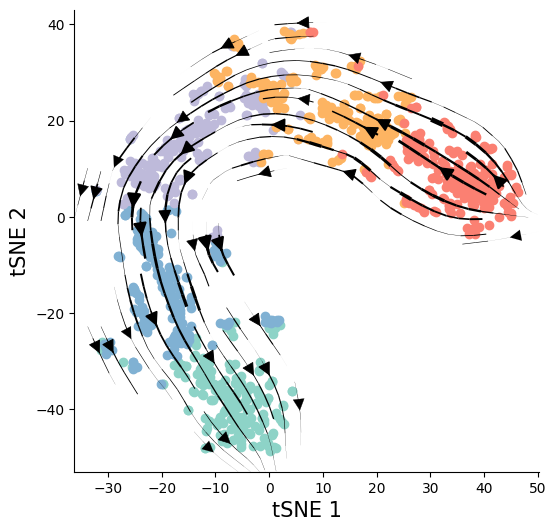

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=2000, arrowsize=2)
# ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-45, 45)

In [41]:
sd = pv.velocity_inference(sd, depths_mp, exact=True)
sd = pv.velocity_embedding(sd)
dir_mp = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

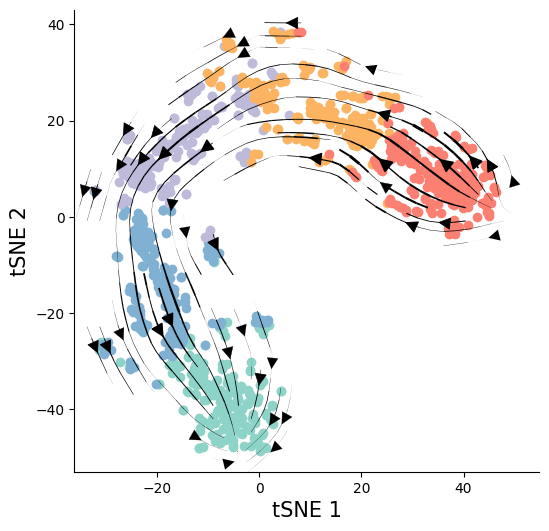

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=2000, arrowsize=2)
# ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-45, 45)

In [47]:
sd = pv.velocity_inference(sd, depths_ml, exact=True)
sd = pv.velocity_embedding(sd)
dir_ml = sd.velocity_embeded[:,0]/np.sqrt((sd.velocity_embeded**2).sum(axis=1))

  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

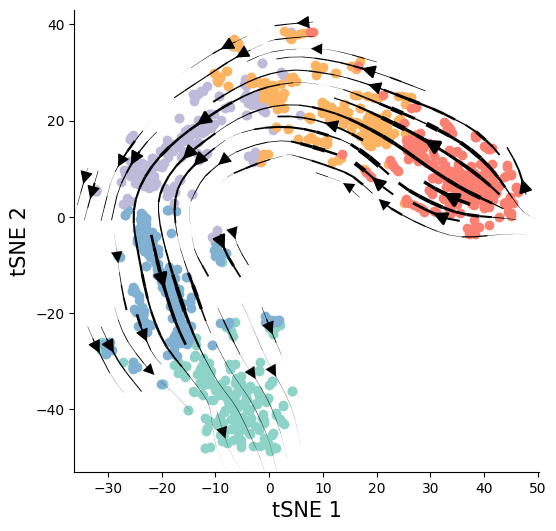

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=2000, arrowsize=2)
# ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim(-45, 45)

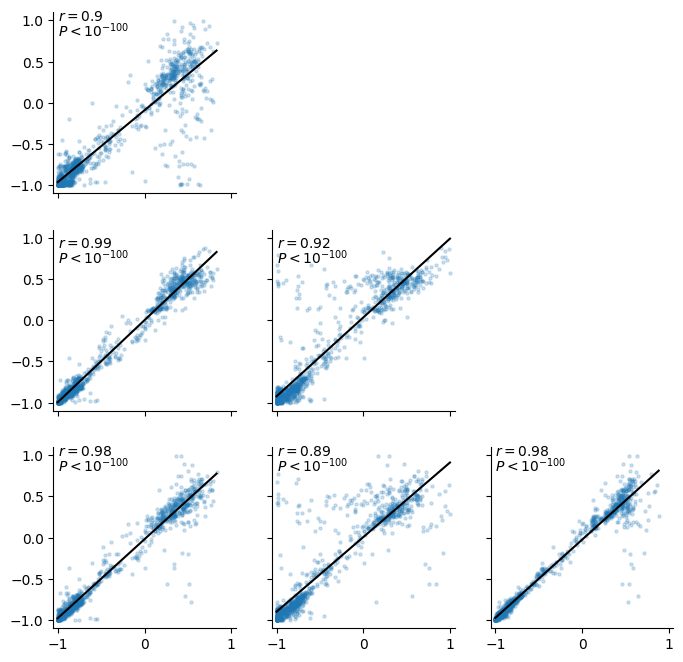

In [51]:
dirs = [dir_gt, dir_mp, dir_nj, dir_ml]
labels = ['Ground truth', 'MP', 'NJ', 'ML']

from scipy.stats import pearsonr

fig, ax = plt.subplots(3,3,figsize=(8,8), sharex=True, sharey=True)
for i in range(1, 4):
    for j in range(i):
        corr_plot(dirs[j], dirs[i], ax[i-1][j])
        ax[i-1][j].set_xlim(-1.05, 1.05)
for i in range(2):
    for j in range(i+1, 3):
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False) 
        ax[i][j].spines['bottom'].set_visible(False) 
        ax[i][j].spines['left'].set_visible(False) 
        ax[i][j].axes.xaxis.set_visible(False)
        ax[i][j].axes.yaxis.set_visible(False)
